**CREDIT CARD FRAUD DETECTION**
====

# Part 1: Reading the input data file and storing to DataFrame

In [5]:
from pyspark.sql.types import *
import sys
import os
sqlContext = SQLContext(sc)

###Read input file and convert it to RDD.
1. Read from file system
2. split columns
3. filter header
4. filter empty rows

In [6]:
filename = '/vagrant/PS_20174392719_1491204439457_log.csv'

def convertToTransactionSchema(arr):
    res = arr
    res[0] = int(arr[0]) # step
    res[2] = float(arr[2]) # amount
    res[4] = float(arr[4]) # old balance
    res[5] = float(arr[5]) # new balance
    res[7] = float(arr[7]) # old balance destination
    res[8] = float(arr[8]) # new balance destination
    res[9] = int(arr[9]) # is fraud
    res[10] = int(arr[10]) # is flagged fraud
    return res

transactionsRDD = (sc.textFile(filename)
       .map(lambda line: line.split(","))
       .filter(lambda line: line[0] != "step")
       .filter(lambda line: len(line)>1)
       .map(convertToTransactionSchema))

###Convert transactionsRDD into DataFrame and cache it.

In [7]:
transactionSchema = StructType([
    StructField("step", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("amount", FloatType(), True),
    StructField("nameOrig", StringType(), True),
    StructField("oldbalanceOrig", FloatType(), True),
    StructField("newbalanceOrig", FloatType(), True),
    StructField("nameDest", StringType(), True),
    StructField("oldbalanceDest", FloatType(), True),
    StructField("newbalanceDest", FloatType(), True),
    StructField("isFraud", IntegerType(), True),
    StructField("isFlaggedFraud", IntegerType(), True)])

transactionsDF = sqlContext.createDataFrame(transactionsRDD, transactionSchema)
transactionsDF.cache()
print transactionsDF.take(2)

[Row(step=1, type=u'PAYMENT', amount=9839.6396484375, nameOrig=u'C1231006815', oldbalanceOrig=170136.0, newbalanceOrig=160296.359375, nameDest=u'M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0), Row(step=1, type=u'PAYMENT', amount=1864.280029296875, nameOrig=u'C1666544295', oldbalanceOrig=21249.0, newbalanceOrig=19384.720703125, nameDest=u'M2044282225', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0)]


###Check if the DataFrame is cached.

In [8]:
transactionsDF.is_cached

True

# Part 2: Data Cleaning

###The purpose of data cleaning is to check if there is any invalid or missing values, and eliminate those reords.

###Print the datatype for each column.

In [9]:
print transactionsDF.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: float (nullable = true)
 |-- newbalanceOrig: float (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: float (nullable = true)
 |-- newbalanceDest: float (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

None


###We need to check each column for invalid values. The set of invalid values depends on the data type of the columns:
1. For columns with string type: empty or null values.
2. Otherwise: null or minus values.

###Firstly, we need to get columns that has 'string' datatype and store it in a variable.

In [10]:
stringCols = []
for (colName, colType) in transactionsDF.dtypes:
    if(colType == 'string'):
        stringCols.append(colName)
        
print stringCols

['type', 'nameOrig', 'nameDest']


###Then, we count the number of invalid values in each column and show the result.

In [11]:
from pyspark.sql.functions import *
from pyspark.sql import *
#from IPython.display import display

def isInvalidValue(colName):
    print(colName)
    if colName in stringCols:
        return (col(colName).isNull() | (col(colName) == ''))
    else:
        return (col(colName).isNull() | (col(colName) < 0))

transactionsDF.select([count(when(isInvalidValue(c), c)).alias(c) for c in transactionsDF.columns]).show()

step
type
amount
nameOrig
oldbalanceOrig
newbalanceOrig
nameDest
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrig|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|             0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+



###As shown, the dataset does not contain any invalid values so we do not need to elminate any records.

## Part 3: Exploring the dataset

###First, we would explore some basic information in the dataset:

1. Number of fraudulent transactions
2. Types of the fraudulent transactions
3. What determines whether the feature isFlaggedFraud gets set or not?
4. Statistics of each column
5. Correllation analysis

###1. Number and percentage of fraudulent transactions and show the records

In [12]:
fraudulentTransactions = transactionsDF.filter(transactionsDF.isFraud == 1)
fraudulentTransactions.show()
print "The total number of fraudulent records = ", fraudulentTransactions.count()
print "The percentage of fraudulent records = %f%%" % ( float(fraudulentTransactions.count())/transactionsDF.count()*100)

+----+--------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1|TRANSFER|    181.0|C1305486145|         181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|         181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1|TRANSFER|   2806.0|C1420196421|        2806.0|           0.0| C972765878|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   2806.0|C2101527076|        2806.0|           0.0|C1007251739|       26202.0|           0.0|      1|             0|
|   1|TRANSFER|  20128.0| C137533655|       20128.0|           0.0|C1

###2. Types of the fraudulent transactions

In [13]:
fraudulentTransactions.groupBy(fraudulentTransactions.type).count().show()

+--------+-----+
|    type|count|
+--------+-----+
|CASH_OUT| 4116|
|TRANSFER| 4097|
+--------+-----+



We can see there are two fradulent types of transactions, `CASH_OUT` and `TRANSFER`.

###3. What determines whether the feature `isFlaggedFraud` gets set or not?
In the overview of the dataset, `isFlaggedFraud` is defined as: "An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction." Now, we will check if the dataset agrees to the description given.

In [27]:
dfFlagged = transactionsDF.filter(transactionsDF.isFlaggedFraud == 1).cache()
flaggedTypes = dfFlagged.map(lambda x: x.type).distinct()
allTypes = transactionsDF.map(lambda x: x.type).distinct()

print('The transaction types available are: \n')
for t in allTypes.collect():
    print(t + '\n')

print('The type of transactions in which isFlaggedFraud is set:\n')
for t in flaggedTypes.collect():
    print(t + '\n')

The transaction types available are: 

TRANSFER

CASH_IN

DEBIT

PAYMENT

CASH_OUT

The type of transactions in which isFlaggedFraud is set:

TRANSFER



Out of `TRANSFER`, `CASH_IN`, `DEBIT`, `PAYMENT`, and `CASH_OUT`, only `TRANSFER` type gets the `isFlaggedFraud` set as 1 (true). This still agrees with the description in the dataset overview. Now, we will check the minimum amount of money transferred in the transaction that has `isFlaggedFraud` set.

In [40]:
print('Minimum amount transferred when isFlaggedFraud is set: ' +
      str(dfFlagged.map(lambda x: x.amount).min()))

Minimum amount transferred when isFlaggedFraud is set: 353874.21875


This result contradicts with the description that says any money transfer above 200,000 is flagged as fraud. Also, we already have another column `isFraud` which is the actual value whether or not the transaction is a fraud. This value should be the only benchmark and `isFlaggedFraud` is redundant, so we will drop this column.

In [42]:
# Drop 'isFlaggedFraud'
transactionsDF.drop('isFlaggedFraud')

DataFrame[step: int, type: string, amount: float, nameOrig: string, oldbalanceOrig: float, newbalanceOrig: float, nameDest: string, oldbalanceDest: float, newbalanceDest: float, isFraud: int]

###4. General Statistics
Here are some general statistics to give us a better idea of how the data looks like. First, let's take a look at the distribution of transaction type.

In [50]:
# Prepare data to show transaction type distribution
groupedByTypes = transactionsDF.map(lambda x: (x.type, 1)).reduceByKey(lambda a, b: a + b)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = groupedByTypes.map(lambda (x, y): x).collect()
sizes = groupedByTypes.map(lambda (x, y): y).collect()

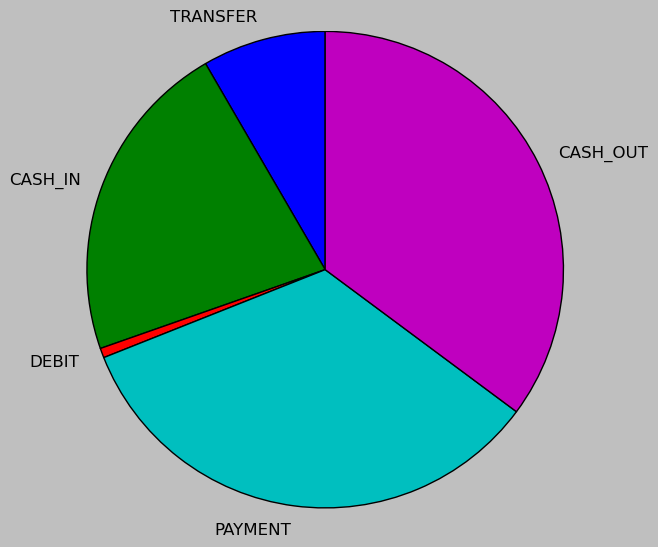

In [51]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Next we will look at the transaction amounts.

In [54]:
transactionsDF.describe('amount').show()

+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|           6362620|
|   mean|179861.90355799912|
| stddev| 603858.2316772835|
|    min|               0.0|
|    max|        9.244552E7|
+-------+------------------+



###5. Correlation analysis

## Part 4: Building the fraud detection model

## Part 5: Evaluating the fraud detection model

## Part 6: Analyzing the fraud detection model